# E13 - Analyze class homeworks


Elaborado por GRUPO 1:

- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [1]:
#pip install textblob

In [2]:
# Librerias
import pandas as pd
import numpy as np
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

#conda install -c conda-forge wordcloud
from wordcloud import WordCloud

In [3]:
# Data
data = pd.read_excel('DataSet/Consolidado_respuestas_escribir_v2.xlsx',index_col=0)
df = pd.DataFrame(data)

#### Limpieza y normalización de datos

En este aspecto:
- Se realiza la normalización del texto de toda la base. 
- Se categorizan los NaN en una categoría 'No reporta'.
- Se estandalizan todos los textos en minúscula, eliminando puntos, tildes y caracteres especiales. 
- Para el caso de carrera de pregrado y sector en el que trabaja se realiza una estandarización entre los conceptos de las variables.

In [4]:
# edad como entero
df['Edad'] = df['Edad'].replace(np.nan,0)
df['Edad'] = df['Edad'].astype(int)

In [5]:
# reemplazar nan
df = data.replace(np.nan,"No reporta")

In [6]:
# eliminar dígitos
digits = ['0','1','2','3','4','5','6','7','8','9']
cols = df.select_dtypes(include=[np.object]).columns
for digit in digits:
    df[cols] = df[cols].apply(lambda x: x.str.replace(digit, ''))

In [7]:
# eliminar caracteres especiales
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
cols = df.select_dtypes(include=[np.object]).columns
for char in spec_chars:
    df[cols] = df[cols].apply(lambda x: x.str.replace(char, ''))

In [8]:
# eliminar minúsculas
cols = df.select_dtypes(include=[np.object]).columns
df[cols] = df[cols].apply(lambda x: x.str.lower())

In [9]:
# eliminar tíldes
cols = df.select_dtypes(include=[np.object]).columns
df[cols] = df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

In [10]:
# creación categoría estudiantes con doble titulacion 
df['Carrera de pregrado'] = df['Carrera de pregrado'].replace("ingenieria indistrial, admon neg internacionales","doble titulacion")
df['Carrera de pregrado'] = df['Carrera de pregrado'].replace("ingenieria industrial y economia","doble titulacion")
df['Carrera de pregrado'] = df['Carrera de pregrado'].replace("biologia e ingenieria biomedica","doble titulacion")

In [11]:
# normalización variable carrera de pregrado
df['Carrera de pregrado'] = df['Carrera de pregrado'].replace("economista","economia")
df['Carrera de pregrado'] = df['Carrera de pregrado'].replace("ingeniera de sistemas","ingenieria de sistemas")
df['Carrera de pregrado'] = df['Carrera de pregrado'].replace("ing. electronica","ingenieria electronica")

In [12]:
# normalizacion variable sector en el que trabaja
df['Sector en el que trabaja'] = df['Sector en el que trabaja'].replace("data scientist - banca","financiero")
df['Sector en el que trabaja'] = df['Sector en el que trabaja'].replace("pensiones","financiero")
df['Sector en el que trabaja'] = df['Sector en el que trabaja'].replace("infraestructura detransporte","infraestructura de transporte")
df['Sector en el que trabaja'] = df['Sector en el que trabaja'].replace("consultoria  de negocios y tecnologia","consultoria de negocios y tecnologia")

In [13]:
df.head()

,Genero,Carrera de pregrado,Sector en el que trabaja,Edad,E1 - Examples of Time Series Analysis,E4 - Panel Data,E6 - Decison Trees,E8 - Ensemble Trees Overview,E10 - REST-API,E12 - Natural Language Processing Overview
ID,,,,,,,,,,
1,m,matematicas,estudio de mercados,30,dentro de las diferentes aplicaciones que tien...,la principal diferencia entre las series de ti...,los arboles de decision son herramienta de mac...,al proponer un metodo para realizar una predic...,durante el desarrollo de soluciones dentro de ...,la empresa koreai se especializa en la impleme...
2,m,no reporta,no reporta,0,no reporta,una serie de tiempo se enfoca en un individio ...,no reporta,no reporta,un micro servicio es una parte de la arquitect...,no reporta
3,m,no reporta,no reporta,0,mercados energeticos tras la liberacion y desr...,los datos de series de tiempo son un conjunto ...,no reporta,los metodos de ensamble nos permiten mejorar e...,los microservicios defininen una nueva metodol...,no reporta
4,m,estadistica,financiero,28,las series de tiempo son una coleccion de obse...,los datos de series de tiempo son un conjunto ...,un arbol de decision es una especie de mapa en...,los metodos de ensamble de modelos o metodos c...,los microservicios son tanto un estilo de arqu...,la funcion de autocompletar las palabras en wh...
5,m,no reporta,no reporta,0,actualmente la empresa de mascotas laika quie...,un conjunto de datos de una serie de tiempo co...,no reporta,los modelos de ensamble consisten en mezclar l...,los microservicios son tanto un estilo de arqu...,no reporta


# Exercise 13.1

Analyze the writing patterns of each student

Para realizar el análisis de patrones de escritura, se separa la variable edad en rangos, validando que las variables carrera de pregrado y sector en el que trabaja tengan la estandarización del punto anterior.

#### Descriptive Analysis

In [51]:
print('Edad:')
pd.cut(data['Edad'], ['Null', 25, 28, 30, 34, 53], labels=['No reporta','25-28', '28-30', '30-34', '34-53']).value_counts()

Edad:


ValueError: could not convert string to float: 'Null'

In [56]:
data['Edad'].describe()

count    38.000000
mean     23.210526
std      16.253329
min       0.000000
25%       0.000000
50%      28.500000
75%      32.500000
max      53.000000
Name: Edad, dtype: float64

Los estudiantes encuestados 

In [16]:
print('Genero:')
df['Genero'].value_counts()

Genero:


m    28
f    10
Name: Genero, dtype: int64

De los estudiantes encuestados, 28 son hombres y 10 son mujeres.

In [17]:
print('Carrera de pregrado:')
df['Carrera de pregrado'].value_counts()

Carrera de pregrado:


no reporta                                         11
ingenieria industrial                               7
estadistica                                         6
economia                                            3
ingenieria de sistemas                              3
ingenieria electronica                              2
doble titulacion                                    2
ing electronica                                     1
finanzas                                            1
matematicas                                         1
ingenieria indistrial admon neg internacionales     1
Name: Carrera de pregrado, dtype: int64

La mayoría de los estudiantes no reportó su carrera de pregrado; por ello, fue ncesario crear una categoría de "no reporta" para evitar eliminar inormación. Dentro de los que reportaron, la mayoría son ingenieros industriales.

In [18]:
print('Sector en el que trabaja:')
df['Sector en el que trabaja'].value_counts()

Sector en el que trabaja:


financiero                              11
no reporta                              11
consumo masivo                           2
fintech                                  2
publico                                  1
ingenieria de software                   1
consultoria de negocios y tecnologia     1
cultura                                  1
data scientist  banca                    1
telecomunicaciones                       1
infraestructura de transporte            1
operaciones                              1
estudio de mercados                      1
electrico y de comunicaciones            1
educacion                                1
salud                                    1
Name: Sector en el que trabaja, dtype: int64

Del total, 11 estudiantes no reportaron el sector donde trabaja; por ello, fue ncesario crear una categoría de "no reporta" para evitar eliminar información. Dentro de los que reportaron, la mayoría trabja en el sector financiero.

#### Matrices of Token by Homework

In [19]:
#pip install nltk
#nltk.download('stopwords')

In [20]:
import nltk
from nltk.corpus import stopwords
spanish_stopwords = stopwords.words('spanish')

In [21]:
# se agregan n-gramas al stopwords
spanish_stopwords.append("no reporta")
spanish_stopwords.append("xyz")

In [22]:
# create document-term matrices
X1 = df['E1 - Examples of Time Series Analysis']
X2 = df['E4 - Panel Data']
X3 = df['E6 - Decison Trees']
X4 = df['E8 - Ensemble Trees Overview']
X5 = df['E10 - REST-API']
X6 = df['E12 - Natural Language Processing Overview']

# use CountVectorizer to create document-term matrices from X
vect1 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X1_dtm = vect1.fit_transform(X1)

vect2 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X2_dtm = vect2.fit_transform(X2)

vect3 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X3_dtm = vect3.fit_transform(X3)

vect4 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X4_dtm = vect4.fit_transform(X4)

vect5 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X5_dtm = vect5.fit_transform(X5)

vect6 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X6_dtm = vect6.fit_transform(X6)

In [23]:
# rows are comments, columns are terms (aka "tokens" or "features")
print('Exercise ( Number of comments , Number of terms)')
print('E1',X1_dtm.shape)
print('E4',X2_dtm.shape)
print('E6',X3_dtm.shape)
print('E8',X4_dtm.shape)
print('E10',X5_dtm.shape)
print('E12',X6_dtm.shape)

Exercise ( Number of comments , Number of terms)
E1 (38, 1594)
E4 (38, 976)
E6 (38, 1444)
E8 (38, 1245)
E10 (38, 1676)
E12 (38, 1666)


In [24]:
print('Total terms E1',len(vect1.vocabulary_))
print('Word:Time')
print(vect1.vocabulary_)

Total terms E1 1594
Word:Time
{'dentro': 406, 'diferentes': 463, 'aplicaciones': 94, 'series': 1363, 'tiempo': 1443, 'vida': 1563, 'real': 1241, 'encuentran': 525, 'precio': 1136, 'cualquier': 347, 'activo': 15, 'largo': 828, 'gran': 702, 'importancia': 754, 'dado': 370, 'reflejan': 1273, 'general': 683, 'mercados': 920, 'medio': 909, 'bolsas': 161, 'valores': 1533, 'new': 997, 'york': 1592, 'tokio': 1452, 'mas': 880, 'localmente': 853, 'colombia': 249, 'peru': 1105, 'analisis': 71, 'relacionado': 1287, 'tipo': 1448, 'siempre': 1369, 'interes': 801, 'economico': 493, 'volumenes': 1583, 'dinero': 468, 'estan': 581, 'presentes': 1152, 'importantes': 756, 'mundo': 975, 'parte': 1064, 'medicina': 903, 'importante': 755, 'monitorear': 954, 'signos': 1372, 'pueden': 1226, 'ser': 1358, 'presion': 1153, 'arterial': 104, 'glucosa': 696, 'hormonas': 731, 'produce': 1183, 'sistema': 1380, 'endocrino': 527, 'saturacion': 1331, 'oxigeno': 1045, 'seguimiento': 1340, 'prediccion': 1141, 'permite': 10

In [25]:
print('Total terms E4',len(vect2.vocabulary_))
print('Word:Time')
print(vect2.vocabulary_)

Total terms E4 976
Word:Time
{'principal': 697, 'diferencia': 270, 'series': 818, 'tiempo': 874, 'datos': 223, 'panel': 640, 'analiza': 33, 'regularmente': 764, 'solo': 840, 'variable': 937, 'resultado': 784, 'intervalo': 501, 'definido': 231, 'lado': 513, 'dado': 217, 'observaciones': 610, 'mismos': 567, 'individuos': 483, 'estudio': 364, 'permite': 660, 'analizar': 35, 'forma': 414, 'mas': 535, 'detallada': 251, 'completa': 153, 'cambios': 97, 'nivel': 600, 'total': 889, 'estan': 348, 'desagregados': 240, 'puede': 726, 'eliminar': 307, 'sesgo': 819, 'trabajar': 894, 'agrupados': 22, 'ademas': 11, 'pueden': 727, 'incorporar': 473, 'caracteristicas': 104, 'inobservables': 494, 'efectos': 298, 'temporales': 865, 'forman': 415, 'parte': 645, 'heterogeneidad': 441, 'observable': 608, 'general': 424, 'caso': 107, 'objetivo': 607, 'dentro': 237, 'desventajas': 250, 'respecto': 782, 'analisis': 32, 'principalmente': 699, 'obtencion': 617, 'procesamiento': 702, 'informacion': 488, 'permanenci

In [26]:
print('Total terms E6',len(vect3.vocabulary_))
print('Word:Time')
print(vect3.vocabulary_)

Total terms E6 1444
Word:Time
{'arboles': 87, 'decision': 371, 'herramienta': 685, 'machine': 821, 'learning': 800, 'supervisado': 1305, 'permite': 985, 'partir': 974, 'diferentes': 432, 'decisiones': 372, 'nodos': 918, 'ir': 784, 'tomando': 1346, 'basadas': 125, 'variables': 1411, 'cuantitativas': 349, 'cualitativas': 346, 'llegar': 813, 'nodo': 917, 'final': 610, 'ser': 1249, 'tomada': 1344, 'dicha': 425, 'observacion': 937, 'dentro': 386, 'usos': 1382, 'encuentran': 486, 'problemas': 1073, 'clasificacion': 226, 'regresion': 1150, 'finalidad': 612, 'realizar': 1127, 'generar': 661, 'modelo': 879, 'clasificar': 231, 'dos': 459, 'mas': 834, 'respuestas': 1190, 'ejemplos': 473, 'comunes': 276, 'utilizando': 1395, 'informacion': 754, 'encuentra': 485, 'base': 130, 'datos': 363, 'bancos': 120, 'determinar': 417, 'retencion': 1196, 'clientes': 235, 'deferentes': 374, 'tipos': 1339, 'servicios': 1254, 'ofrecidos': 947, 'banco': 119, 'tarjetas': 1315, 'credito': 338, 'ejemplo': 472, 'caracte

In [27]:
print('Total terms E8',len(vect4.vocabulary_))
print('Word:Time')
print(vect4.vocabulary_)

Total terms E8 1245
Word:Time
{'proponer': 920, 'metodo': 710, 'realizar': 962, 'prediccion': 870, 'debe': 314, 'usar': 1181, 'base': 110, 'particion': 811, 'informacion': 614, 'casos': 164, 'pueden': 929, 'presentar': 882, 'problemas': 896, 'seleccion': 1040, 'muestra': 739, 'entrenamiento': 431, 'algoritmo': 36, 'adicionalmente': 14, 'si': 1057, 'consideran': 245, 'diferentes': 356, 'metodos': 712, 'mismo': 725, 'conjunto': 233, 'encontrar': 401, 'soluciones': 1086, 'problema': 895, 'intentado': 625, 'solucionar': 1085, 'evitar': 488, 'ambiguedad': 46, 'hace': 567, 'uso': 1183, 'teorema': 1134, 'dice': 349, 'cualquier': 295, 'combinacion': 191, 'modelos': 732, 'mejor': 696, 'clasificacion': 179, 'aleatoria': 30, 'dicha': 350, 'cualquiera': 296, 'evaluados': 481, 'forma': 523, 'individual': 607, 'asi': 83, 'diferente': 355, 'tipos': 1145, 'ensamblajes': 413, 'primero': 886, 'necesita': 749, 'generar': 550, 'aparte': 58, 'utilizando': 1197, 'inicial': 615, 'bagging': 103, 'bootstrap': 

In [28]:
print('Total terms E10',len(vect5.vocabulary_))
print('Word:Time')
print(vect5.vocabulary_)

Total terms E10 1676
Word:Time
{'desarrollo': 490, 'soluciones': 1515, 'dentro': 465, 'empresas': 618, 'encuentran': 630, 'varias': 1645, 'dificultades': 537, 'tratar': 1594, 'solventar': 1516, 'todas': 1572, 'posibles': 1251, 'necesidades': 1125, 'solo': 1511, 'sistema': 1500, 'servicio': 1476, 'tener': 1556, 'grandes': 838, 'paquete': 1191, 'cada': 198, 'momento': 1100, 'actualizar': 34, 'mejorar': 1058, 'alguna': 77, 'parte': 1197, 'especifica': 693, 'solucion': 1512, 'encuentra': 629, 'gran': 836, 'numero': 1144, 'validaciones': 1638, 'objetos': 1146, 'modificados': 1092, 'experiencia': 737, 'cliente': 243, 'desarrollador': 482, 'arquitectura': 131, 'micro': 1075, 'servicios': 1477, 'permite': 1219, 'medio': 1053, 'varios': 1647, 'llegar': 1003, 'misma': 1081, 'diferentes': 534, 'componentes': 291, 'componente': 290, 'desarrollada': 479, 'liberada': 981, 'escalada': 667, 'forma': 787, 'individual': 909, 'encargar': 623, 'proposito': 1314, 'especifico': 696, 'viviran': 1669, 'mismo'

In [29]:
print('Total terms E12',len(vect6.vocabulary_))
print('Word:Time')
print(vect6.vocabulary_)

Total terms E12 1666
Word:Time
{'empresa': 565, 'koreai': 908, 'especializa': 631, 'implementacion': 831, 'asistentes': 137, 'virtuales': 1646, 'diferentes': 503, 'sectores': 1409, 'bancos': 184, 'seguros': 1418, 'empresas': 566, 'sector': 1408, 'salud': 1402, 'retail': 1379, 'canales': 225, 'comunicacion': 334, 'medio': 991, 'chat': 263, 'asesor': 133, 'parte': 1163, 'estrategia': 645, 'mercadeo': 1001, 'asistente': 136, 'virtual': 1645, 'funciona': 736, 'pagina': 1150, 'web': 1661, 'muestra': 1050, 'capacidades': 230, 'tener': 1533, 'soluciones': 1479, 'adaptables': 23, 'cada': 219, 'necesidad': 1066, 'httpskoreaiconversationalaiwhatisavirtualassistant': 802, 'reporta': 1353, 'funcion': 735, 'autocompletar': 156, 'palabras': 1157, 'whatsapp': 1663, 'persona': 1188, 'escribiendo': 617, 'correos': 404, 'hotmail': 800, 'gpt': 755, 'openai': 1122, 'generative': 752, 'pretrained': 1244, 'transformer': 1578, 'inteligencia': 881, 'artificial': 127, 'codigo': 289, 'abierto': 1, 'creada': 416

#### Word Cloud 

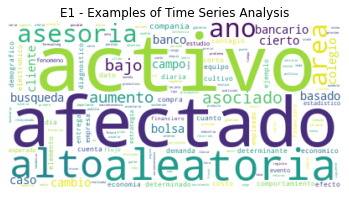

In [30]:
# features - "E1 - Examples of Time Series Analysis"
df1 = vect1.get_feature_names()

#Creating the text variable
text = " ".join(title for title in df1)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("E1 - Examples of Time Series Analysis")
plt.axis("off")
plt.show()

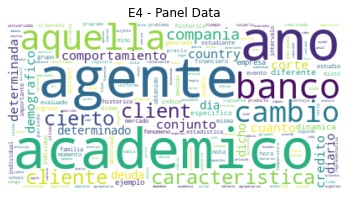

In [31]:
# features - "E4 - Panel Data"
df2 = vect2.get_feature_names()

#Creating the text variable
text = " ".join(title for title in df2)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("E4 - Panel Data")
plt.axis("off")
plt.show()

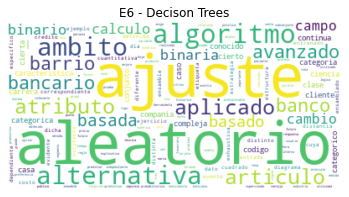

In [32]:
# features - "E6 - Decison Trees"
df3 = vect3.get_feature_names()

#Creating the text variable
text = " ".join(title for title in df3)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("E6 - Decison Trees")
plt.axis("off")
plt.show()

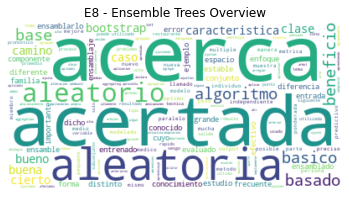

In [33]:
# features - "E8 - Ensemble Trees Overview"
df4 = vect4.get_feature_names()

#Creating the text variable
text = " ".join(title for title in df4)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("E8 - Ensemble Trees Overview")
plt.axis("off")
plt.show()

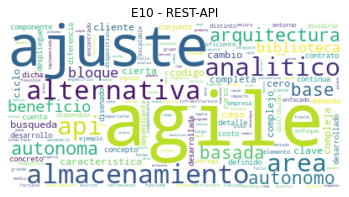

In [34]:
# features - "E10 - REST-API"
df5 = vect5.get_feature_names()

#Creating the text variable
text = " ".join(title for title in df5)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("E10 - REST-API")
plt.axis("off")
plt.show()

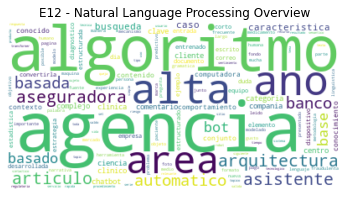

In [35]:
# features - "E12 - Natural Language Processing Overview"
df6 = vect6.get_feature_names()

#Creating the text variable
text = " ".join(title for title in df6)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("E12 - Natural Language Processing Overview")
plt.axis("off")
plt.show()

# Exercise 13.2
Create a classifier to predict the gender of each student

In [36]:
y1 = df.Genero
df['Genero'].unique()

array(['m', 'f'], dtype=object)

In [37]:
results = {}

#(4, 5)
for i in range(1,6):
    vect45 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X45_dtm = vect45.fit_transform(YY[4,5]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X45_dtm, y1, cv=10)).mean()
    #print('accuracy','4:5','ngram=',i,accuracy)
    results['4:5:%d'%i] = accuracy
    
#(4, 6)
for i in range(1,6):
    vect46 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X46_dtm = vect46.fit_transform(YY[4,6]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X46_dtm, y1, cv=10)).mean()
    #print('accuracy','4:6','ngram=',accuracy)
    results['4:6:%d'%i] = accuracy

#(4, 7)
for i in range(1,6):
    vect47 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X47_dtm = vect47.fit_transform(YY[4,7]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X47_dtm, y1, cv=10)).mean()
    #print('accuracy','4:7','ngram=',i,accuracy)
    results['4:7:%d'%i] = accuracy

#(4, 8)
for i in range(1,6):
    vect48 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X48_dtm = vect48.fit_transform(YY[4,8]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X48_dtm, y1, cv=10)).mean()
    #print('accuracy','4:8','ngram=',i,accuracy)
    results['4:8:%d'%i] = accuracy

#(4, 9)
for i in range(1,6):
    vect49 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X49_dtm = vect49.fit_transform(YY[4,9]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X49_dtm, y1, cv=10)).mean()
    #print('accuracy','4:9','ngram=',i,accuracy)
    results['4:9:%d'%i] = accuracy

#(5, 6)
for i in range(1,6):
    vect56 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X56_dtm = vect56.fit_transform(YY[5,6]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X56_dtm, y1, cv=10)).mean()
    #print('accuracy','5:6','ngram=',i,)
    results['5:6:%d'%i] = accuracy

#(5, 7)
for i in range(1,6):
    vect57 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X57_dtm = vect57.fit_transform(YY[5,7]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X57_dtm, y1, cv=10)).mean()
    #print('accuracy','5:7','ngram=',i, accuracy)
    results['5:7:%d'%i] = accuracy

#(5, 8)
for i in range(1,6):
    vect58 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X58_dtm = vect58.fit_transform(YY[5,8]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X58_dtm, y1, cv=10)).mean()
    #print('accuracy','5:8','ngram=',i, accuracy)
    results['5:8:%d'%i] = accuracy

#(5, 9)
for i in range(1,6):
    vect59 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X59_dtm = vect59.fit_transform(YY[5,9]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X59_dtm, y1, cv=10)).mean()
    #print('accuracy','5:9','ngram=',i, accuracy)
    results['5:9:%d'%i] = accuracy

#(6, 7)
for i in range(1,6):
    vect67 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X67_dtm = vect67.fit_transform(YY[6,7]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X67_dtm, y1, cv=10)).mean()
    #print('accuracy','6:7','ngram=',i, accuracy)
    results['6:7:%d'%i] = accuracy

#(6, 8)
for i in range(1,6):
    vect68 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X68_dtm = vect68.fit_transform(YY[6,8]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X68_dtm, y1, cv=10)).mean()
    #print('accuracy','6:8','ngram=',i, accuracy)
    results['6:8:%d'%i] = accuracy

#(6, 9)
for i in range(1,6):
    vect69 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X69_dtm = vect69.fit_transform(YY[6,9]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X69_dtm, y1, cv=10)).mean()
    #print('accuracy','6:9','ngram=',i, accuracy)
    results['6:9:%d'%i] = accuracy

#(7, 8)
for i in range(1,6):
    vect78 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X78_dtm = vect78.fit_transform(YY[7,8]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X78_dtm, y1, cv=10)).mean()
    #print('accuracy','7:8','ngram=',i, accuracy)
    results['7:8:%d'%i] = accuracy

#(7, 9)
for i in range(1,6):
    vect79 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X79_dtm = vect79.fit_transform(YY[7,9]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X79_dtm, y1, cv=10)).mean()
    #print('accuracy','7:9','ngram=',i, accuracy)
    results['7:9:%d'%i] = accuracy

#(8, 9)
for i in range(1,6):
    vect89 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X89_dtm = vect89.fit_transform(YY[8,9]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X89_dtm, y1, cv=10)).mean()
    #print('accuracy','8:9','ngram=',i, accuracy)
    results['8:9:%d'%i] = accuracy

NameError: name 'YY' is not defined

In [ ]:
print('Desde Variable i hasta Variable j con n-grama y accuracy')
result_list=sorted(((value, key) for (key,value) in results.items()) , reverse=True)
sortdict=dict([(k,v) for v,k in result_list])
for k in sortdict:
    print(k,sortdict[k])

El mejor modelo para el género incluye las respuestas de las preguntas 'E4 - Panel Data', 'E6 - Decison Trees' y	'E8 - Ensemble Trees Overview' utilizando unigramas (1-grama), con un accuracy de 79%.

In [ ]:
# best model and predict
Z = X57_dtm
nb.fit(Z,y1)
y_pred = nb.predict(Z)
print('predict')
print('f',np.count_nonzero(y_pred == 'f'))
print('m',np.count_nonzero(y_pred == 'm'))

# real
y1.array
print('')
print('real')
print('f',np.count_nonzero(y1.array == 'f'))
print('m',np.count_nonzero(y1.array == 'm'))

# Exercise 13.3
Create a classifier to predict the industry in which each student works

In [ ]:
y2 = df['Sector en el que trabaja']
df['Sector en el que trabaja'].unique()

In [ ]:
results = {}

#(4, 5)
for i in range(1,6):
    vect45 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X45_dtm = vect45.fit_transform(YY[4,5]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X45_dtm, y2, cv=10)).mean()
    #print('accuracy','4:5','ngram=',i,accuracy)
    results['4:5:%d'%i] = accuracy
    
#(4, 6)
for i in range(1,6):
    vect46 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X46_dtm = vect46.fit_transform(YY[4,6]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X46_dtm, y2, cv=10)).mean()
    #print('accuracy','4:6','ngram=',accuracy)
    results['4:6:%d'%i] = accuracy

#(4, 7)
for i in range(1,6):
    vect47 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X47_dtm = vect47.fit_transform(YY[4,7]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X47_dtm, y2, cv=10)).mean()
    #print('accuracy','4:7','ngram=',i,accuracy)
    results['4:7:%d'%i] = accuracy

#(4, 8)
for i in range(1,6):
    vect48 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X48_dtm = vect48.fit_transform(YY[4,8]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X48_dtm, y2, cv=10)).mean()
    #print('accuracy','4:8','ngram=',i,accuracy)
    results['4:8:%d'%i] = accuracy

#(4, 9)
for i in range(1,6):
    vect49 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X49_dtm = vect49.fit_transform(YY[4,9]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X49_dtm, y2, cv=10)).mean()
    #print('accuracy','4:9','ngram=',i,accuracy)
    results['4:9:%d'%i] = accuracy

#(5, 6)
for i in range(1,6):
    vect56 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X56_dtm = vect56.fit_transform(YY[5,6]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X56_dtm, y2, cv=10)).mean()
    #print('accuracy','5:6','ngram=',i,)
    results['5:6:%d'%i] = accuracy

#(5, 7)
for i in range(1,6):
    vect57 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X57_dtm = vect57.fit_transform(YY[5,7]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X57_dtm, y2, cv=10)).mean()
    #print('accuracy','5:7','ngram=',i, accuracy)
    results['5:7:%d'%i] = accuracy

#(5, 8)
for i in range(1,6):
    vect58 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X58_dtm = vect58.fit_transform(YY[5,8]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X58_dtm, y2, cv=10)).mean()
    #print('accuracy','5:8','ngram=',i, accuracy)
    results['5:8:%d'%i] = accuracy

#(5, 9)
for i in range(1,6):
    vect59 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X59_dtm = vect59.fit_transform(YY[5,9]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X59_dtm, y2, cv=10)).mean()
    #print('accuracy','5:9','ngram=',i, accuracy)
    results['5:9:%d'%i] = accuracy

#(6, 7)
for i in range(1,6):
    vect67 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X67_dtm = vect67.fit_transform(YY[6,7]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X67_dtm, y2, cv=10)).mean()
    #print('accuracy','6:7','ngram=',i, accuracy)
    results['6:7:%d'%i] = accuracy

#(6, 8)
for i in range(1,6):
    vect68 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X68_dtm = vect68.fit_transform(YY[6,8]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X68_dtm, y2, cv=10)).mean()
    #print('accuracy','6:8','ngram=',i, accuracy)
    results['6:8:%d'%i] = accuracy

#(6, 9)
for i in range(1,6):
    vect69 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X69_dtm = vect69.fit_transform(YY[6,9]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X69_dtm, y2, cv=10)).mean()
    #print('accuracy','6:9','ngram=',i, accuracy)
    results['6:9:%d'%i] = accuracy

#(7, 8)
for i in range(1,6):
    vect78 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X78_dtm = vect78.fit_transform(YY[7,8]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X78_dtm, y2, cv=10)).mean()
    #print('accuracy','7:8','ngram=',i, accuracy)
    results['7:8:%d'%i] = accuracy

#(7, 9)
for i in range(1,6):
    vect79 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X79_dtm = vect79.fit_transform(YY[7,9]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X79_dtm, y2, cv=10)).mean()
    #print('accuracy','7:9','ngram=',i, accuracy)
    results['7:9:%d'%i] = accuracy

#(8, 9)
for i in range(1,6):
    vect89 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, i))
    X89_dtm = vect89.fit_transform(YY[8,9]['sum'])
    nb = MultinomialNB()
    accuracy = pd.Series(cross_val_score(nb, X89_dtm, y2, cv=10)).mean()
    #print('accuracy','8:9','ngram=',i, accuracy)
    results['8:9:%d'%i] = accuracy

In [ ]:
print('Desde Variable i hasta Variable j con n-grama y accuracy')
result_list=sorted(((value, key) for (key,value) in results.items()) , reverse=True)
sortdict=dict([(k,v) for v,k in result_list])
for k in sortdict:
    print(k,sortdict[k])

El mejor modelo para el género incluye las respuestas de las preguntas 'E4 - Panel Data', 'E6 - Decison Trees' y 'E8 - Ensemble Trees Overview' utilizando unigramas (1-grama), con un accuracy de 45%.

In [ ]:
# best model and predict
vect57 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X57_dtm = vect57.fit_transform(YY[5,7]['sum'])
nb.fit(X57_dtm,y2)
y_pred = nb.predict(X57_dtm)

print('financiero',np.count_nonzero(y_pred == 'financiero'))
print('no reporta',np.count_nonzero(y_pred == 'no reporta'))
print('fintech',np.count_nonzero(y_pred == 'fintech'))
print('consumo masivo ',np.count_nonzero(y_pred == 'consumo masivo'))
print('electrico y de comunicaciones ',np.count_nonzero(y_pred == 'electrico y de comunicaciones'))
print('educacion',np.count_nonzero(y_pred == 'educacion'))
print('operaciones',np.count_nonzero(y_pred == 'operaciones'))
print('estudio de mercados',np.count_nonzero(y_pred == 'estudio de mercados'))
print('publico',np.count_nonzero(y_pred == 'publico'))
print('telecomunicaciones',np.count_nonzero(y_pred == 'telecomunicaciones'))
print('ingenieria de software',np.count_nonzero(y_pred == 'ingenieria de software'))
print('salud',np.count_nonzero(y_pred == 'salud'))
print('cultura',np.count_nonzero(y_pred == 'cultura'))
print('consultoria de negocios y tecnologia',np.count_nonzero(y_pred == 'consultoria de negocios y tecnologia'))
print('infraestructura de transporte',np.count_nonzero(y_pred == 'infraestructura de transporte'))

In [ ]:
# real
y2.array

print('financiero',np.count_nonzero(y2.array == 'financiero'))
print('no reporta',np.count_nonzero(y2.array == 'no reporta'))
print('fintech',np.count_nonzero(y2.array == 'fintech'))
print('consumo masivo ',np.count_nonzero(y2.array == 'consumo masivo'))
print('electrico y de comunicaciones ',np.count_nonzero(y2.array == 'electrico y de comunicaciones'))
print('educacion',np.count_nonzero(y2.array == 'educacion'))
print('operaciones',np.count_nonzero(y2.array == 'operaciones'))
print('estudio de mercados',np.count_nonzero(y2.array == 'estudio de mercados'))
print('publico',np.count_nonzero(y2.array == 'publico'))
print('telecomunicaciones',np.count_nonzero(y2.array == 'telecomunicaciones'))
print('ingenieria de software',np.count_nonzero(y2.array == 'ingenieria de software'))
print('salud',np.count_nonzero(y2.array == 'salud'))
print('cultura',np.count_nonzero(y2.array == 'cultura'))
print('consultoria de negocios y tecnologia',np.count_nonzero(y2.array == 'consultoria de negocios y tecnologia'))
print('infraestructura de transporte',np.count_nonzero(y2.array == 'infraestructura de transporte'))